In [264]:
import pandas as pd
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Normalization, Dense, Dropout, Normalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


# Index
* [Encoding the Target](#Encoding-the-Target)
* [Split](#Split)
* [Train the Model](#Train-the-Model)
* [Testing](#Testing)
* [Saving the Model](#Saving-the-Model)

# Encoding the Target

[Index](#Index)

[`regression`](https://www.tensorflow.org/tutorials/keras/regression)
[`layers/Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)

In [265]:
dataframe=pd.read_csv('/tf/ML-project/data/processedDataframe.csv')

In [266]:
# Ejemplo con LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(dataframe["fuzzyCategory"])

In [267]:
dataframe.drop(columns=["Category"]).head(2)

,fuzzyCategory,Nutrient Data Bank Number,Data.Alpha Carotene,Data.Ash,Data.Beta Carotene,Data.Beta Cryptoxanthin,Data.Carbohydrate,Data.Cholesterol,Data.Choline,Data.Fiber,...,Data.Major Minerals.Potassium,Data.Major Minerals.Sodium,Data.Major Minerals.Zinc,Data.Vitamins.Vitamin A - IU,Data.Vitamins.Vitamin A - RAE,Data.Vitamins.Vitamin B12,Data.Vitamins.Vitamin B6,Data.Vitamins.Vitamin C,Data.Vitamins.Vitamin E,Data.Vitamins.Vitamin K
0,butter,1001,0,2.11,158,0,0.06,215,19,0.0,...,24,576,0.09,2499,684,0.17,0.003,0.0,2.32,7.0
1,butter,1002,0,2.11,158,0,0.06,219,19,0.0,...,26,827,0.05,2499,684,0.13,0.003,0.0,2.32,7.0


# Split
[Index](#Index)

In [268]:
X, y = dataframe.drop(columns=["Category","fuzzyCategory"]), y_encoded

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Train the Model
[Index](#Index)

In [269]:
learning_rate = 0.0001  # Esta es una tasa de aprendizaje comúnmente usada.
optimizer = Adam(learning_rate=learning_rate)

In [270]:
# Número de características de entrada y clases de salida
n_features = len(X.columns)
n_classes = pd.Series(y_encoded).nunique()

# Crear el modelo
model = Sequential([
    Normalization(input_shape=(n_features,)),  # Capa de normalización
    Dense(128, activation='relu'),  # Primera capa oculta
    Dense(256, activation='relu'),  # Segunda capa oculta con regularización L1_L2
    Dropout(0.2),  # Capa de Dropout
    Dense(256, activation='relu'),  # Segunda capa oculta con regularización L1_L2
    Dropout(0.2),  # Capa de Dropout
    Dense(256, activation='relu'),  # Segunda capa oculta con regularización L1_L2
    Dropout(0.2),  # Capa de Dropout
    Dense(256, activation='relu'),  # Segunda capa oculta con regularización L1_L2
    Dropout(0.2),  # Capa de Dropout
    Dense(256, activation='relu'),  # Tercera capa oculta
    Dense(n_classes, activation='softmax')  # Capa de salida
])

# Antes de compilar el modelo, debes adaptar la capa de Normalization a tus datos
# Esto calculará la media y la desviación estándar de tus datos de entrenamiento
# y los usará para la normalización durante el entrenamiento e inferencia.

# Supongamos que 'X_train' son tus datos de entrenamiento
model.layers[0].adapt(X_train.to_numpy())

# Compilar el modelo
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenar el modelo como antes
# model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_25                │ (None, 41)             │            83 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 118)            │        30,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,977 (1.27 MB)

 Trainable params: 331,894 (1.27 MB)

 Non-trainable params: 83 (336.00 B)

In [271]:
# Entrenar el modelo

early_stopper = EarlyStopping(
    monitor='val_loss',  # Monitoriza la pérdida de validación
    patience=5,          # Número de épocas sin mejora después de las cuales se detendrá el entrenamiento
    verbose=1,           # Muestra mensajes cuando se detiene el entrenamiento
    mode='min',          # Detiene el entrenamiento cuando la cantidad monitoreada ha dejado de disminuir
    restore_best_weights=True  # Restaura los pesos del modelo desde la época con el mejor valor de la cantidad monitoreada
)

history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stopper]
)  # Usa el 20% de los datos para validación

Epoch 1/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.0947 - loss: 4.4356 - val_accuracy: 0.1903 - val_loss: 3.6083
Epoch 2/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2022 - loss: 3.5743 - val_accuracy: 0.2285 - val_loss: 3.3606
Epoch 3/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2191 - loss: 3.3576 - val_accuracy: 0.2627 - val_loss: 3.1808
Epoch 4/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2644 - loss: 3.1781 - val_accuracy: 0.3082 - val_loss: 3.0459
Epoch 5/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3091 - loss: 2.9721 - val_accuracy: 0.3330 - val_loss: 2.9319
Epoch 6/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3163 - loss: 2.9404 - val_accuracy: 0.3464 - val_loss: 2.8551
Epoch 7/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3573 - loss: 2.7809 - val_accuracy: 0.3619 - val_loss: 2.7797
Epoch 8/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3719 - loss: 2.6945 - val_accuracy: 0.

# Testing
[Index](#Index)

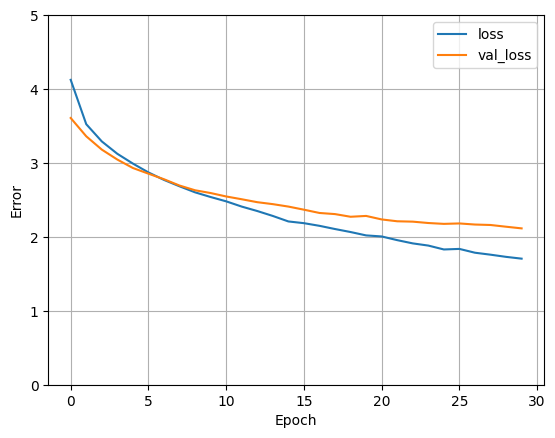

In [276]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [273]:
# Evaluar el modelo con el conjunto de datos de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5632 - loss: 2.0789
Test Loss: 2.0239570140838623
Test Accuracy: 0.5682486295700073


# Saving the Model

In [274]:
model.save('../models/categoryModel.keras')